In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import itertools
import statsmodels.api as sm
import networkx as nx
import seaborn as sns
import pandas as pd

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset
from spikeometric.stimulus import RegularStimulus

from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj, to_networkx

In [2]:
n_obs = 5
n_hidden = 1

#index_obs = np.random.choice(n_obs+n_hidden, size = n_obs, replace = False)
n_networks = 10

# model parameters
mu=0
sigma = 10
theta = 5

generator = NormalGenerator(
    n_neurons=n_obs + n_hidden,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

# set up the neuron model
neuron_model = BernoulliGLM(
    theta=theta,
    dt=1.,
    coupling_window=2,
    abs_ref_scale=2,
    abs_ref_strength=-100,
    rel_ref_scale=0,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2,
    r = 1
)

In [6]:
edge_index = torch.tensor([[0, 0, 1, 2, 4, 5],
                           [1, 2, 2, 3, 1, 2]])

W0 = torch.tensor([6.0, 7.5, 2.2, 2.4, 2.0, 2.1])

dataset = Data(num_nodes=6, W0=W0, edge_index=edge_index)

torch.save(dataset,'data/homemade.pt')
example_network = torch.load('data/homemade.pt')

In [7]:
index_obs = np.array([1,2,3,4, 5])

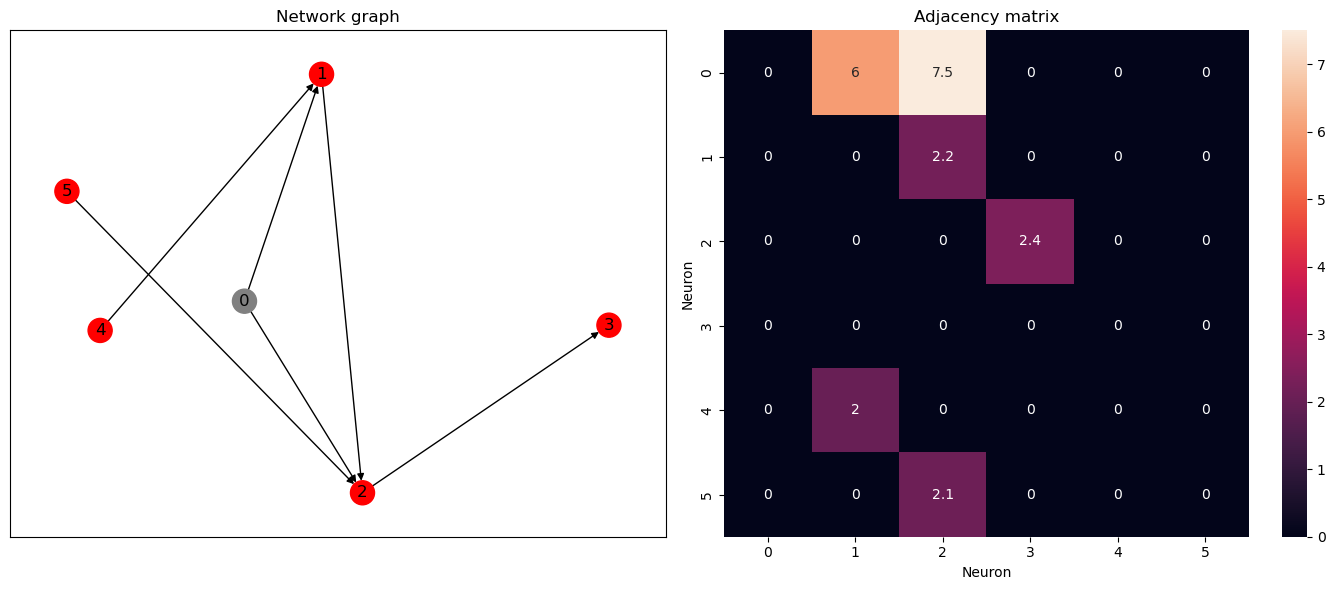

In [8]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

#example_network = network_data[5]
G = to_networkx(example_network)
color_map = ['grey' if node not in index_obs else 'red' for node in G]        

nx.draw_networkx(G, arrows=True, ax=ax[0], node_color=color_map)
ax[0].set_title("Network graph")

W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(W0, ax=ax[1], annot=True)
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

### Run simulation with and without stimulation

In [9]:
# create a data set object (maybe dictionary or a list) that can store the 
# observational and interventional data for the network under study

spike_data = []
n_timesteps = 10**6

# stimulate the observable neurons one by one

for intervention in range(n_obs + 1):
    stimulus_mask = torch.zeros(n_obs+n_hidden, dtype=torch.bool)
    if intervention < n_obs:
        stimulus_mask[index_obs[intervention]] = True
    print(stimulus_mask)
    neuron_model.add_stimulus(lambda t: 2*stimulus_mask)
    spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)
    
    spike_data.append(spikes)
    # save the data
# construct a network based on the observational data
# remove links that are caused by confounding using interventional data (we only look at edges going out of the stimulated cell)

tensor([False,  True, False, False, False, False])
tensor([False, False,  True, False, False, False])
tensor([False, False, False,  True, False, False])
tensor([False, False, False, False,  True, False])
tensor([False, False, False, False, False,  True])
tensor([False, False, False, False, False, False])


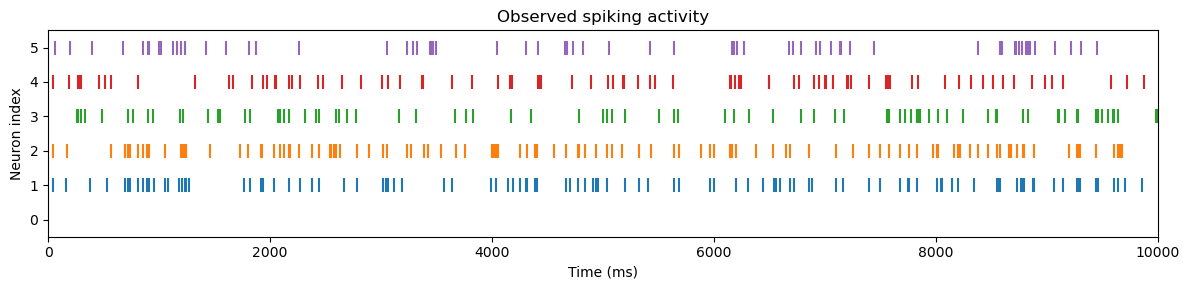

In [63]:
spikes = spike_data[-1]

plt.figure(figsize=(12,3))

for i in index_obs:
    plt.scatter(np.where(spikes[i,:] == 1)[0], i*np.ones_like(np.where(spikes[i,:] == 1)[0]), marker='|', s=100)

plt.yticks(np.arange(n_obs + n_hidden))
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.xlim([0, 10_000])
plt.ylim([-0.5, n_obs + n_hidden - 0.5])
plt.title("Observed spiking activity")
plt.tight_layout()
plt.show()

In [57]:
G_obs = nx.subgraph(G, index_obs)
G_learned = nx.DiGraph()
G_learned.add_nodes_from(np.sort(index_obs))
alpha = 0.01 # sign. level

# observational data
spikes = spike_data[-1]
spikes_obs = spikes[index_obs]

for idx, neuron_id in enumerate(index_obs):
        
    target_spikes = spikes_obs[idx].numpy()
    source_spikes = np.delete(torch.roll(spikes_obs, 1), idx, axis=0) # effect from 1 time step before
    source_spikes2 = np.delete(torch.roll(spikes_obs, 2), idx, axis=0) # effect from 2 time step before
    autoregressive_feature1 = torch.roll(spikes_obs[idx], 1).numpy() # 1 time step history effects
    autoregressive_feature2 = torch.roll(spikes_obs[idx], 2).numpy() # 2 time step history effects
    
    # create design matrix
    X = np.vstack((source_spikes2, autoregressive_feature1, autoregressive_feature2))
    
    # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
    linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
    res = linear_model.fit()
    
    source_nodes = np.delete(index_obs, idx) # remove target neuron
    p_values = res.pvalues[1:n_obs] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
    
    for k, p in enumerate(p_values):
        if p < alpha:
            G_learned.add_edge(source_nodes[k], neuron_id)

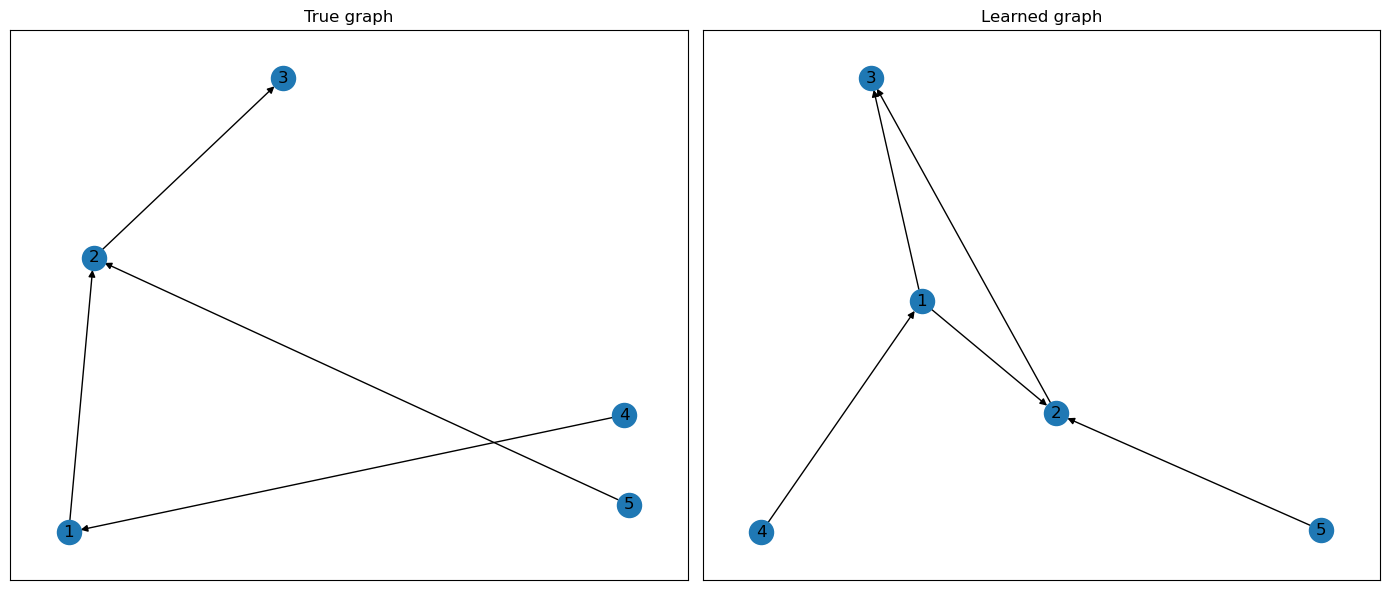

In [58]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

nx.draw_networkx(G_obs, arrows=True, ax=ax[0])
ax[0].set_title("True graph")

nx.draw_networkx(G_learned, arrows=True, ax=ax[1])
ax[1].set_title("Learned graph")

plt.tight_layout()
plt.show()

In [59]:
A_true = nx.adjacency_matrix(G_obs).todense() 
A_learned = nx.adjacency_matrix(G_learned).todense() 

pd.DataFrame(A_true - A_learned)
SHD = np.sum(np.abs(A_true- A_learned))
print(SHD)

1


In [60]:
for intervention in range(n_obs):
    spikes = spike_data[intervention] # get data set where the given intervention occurred
    intervened_neuron = index_obs[intervention]

    print('intervened_neuron = ', intervened_neuron)
    
    # get indeces of neurons that intervened node is correlated with
    target_idx = np.where(A_learned[intervention] == 1)
    target_neurons = index_obs[target_idx[0]]
    
    #print('target_neurons = ', target_neurons)
    
    if len(target_neurons) == 0:
        print('intervened neuron has no targets')
        continue
        
    else:
        # loop through the neurons that the intervened node is observationally correlated with
        for target_neuron in target_neurons:
            target_neuron_idx = np.where(index_obs == target_neuron)[0]
            #print('target_neuron_idx = ', target_neuron_idx)

            sources_idx = np.where(A_learned[:, target_neuron_idx] == 1) # possible explanations for target neuron
            source_neurons = index_obs[sources_idx[0]]
            
            intervened_idx = np.where(source_neurons == intervened_neuron)[0]
            print('intervened_idx = ', intervened_idx)
            
            print('source_neurons = ', source_neurons, 'target_neuron =', target_neuron)

            target_spikes = spikes[target_neuron].numpy()

            source_spikes = torch.roll(spikes[source_neurons], 1).numpy() # effect from 1 time step before
            source_spikes2 = torch.roll(spikes[source_neurons], 2).numpy() # effect from 2 time step before
            autoregressive_feature1 = torch.roll(spikes[target_neuron], 1).numpy() # 1 time step history effects
            autoregressive_feature2 = torch.roll(spikes[target_neuron], 2).numpy() # 2 time step history effects

            # create design matrix
            X = np.vstack((source_spikes, autoregressive_feature1, autoregressive_feature2))

            # use a linear regression model to assess if there is a significantly non-zero association between source and target neuron
            linear_model = sm.OLS(target_spikes.T, sm.add_constant(X.T))
            res = linear_model.fit()
            p_values = res.pvalues[intervened_idx+1] # p-values of t-test of effect from source to targat neuron (first time step coefficient)
            print(res.pvalues)
            print('p_values = ',p_values)
            print(res.pvalues)
            if np.any(p_values > alpha):
                print(f'removed edge ({intervened_neuron}, {target_neuron})')
                G_learned.remove_edge(intervened_neuron, target_neuron)


intervened_neuron =  1
intervened_idx =  [0]
source_neurons =  [1 5] target_neuron = 2
[0.00000000e+000 0.00000000e+000 0.00000000e+000 4.50696275e-235
 1.15168249e-063]
p_values =  [0.]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 4.50696275e-235
 1.15168249e-063]
intervened_idx =  [0]
source_neurons =  [1 2] target_neuron = 3
[0.00000000e+00 9.54229832e-02 0.00000000e+00 1.42785246e-15
 3.58443389e-15]
p_values =  [0.09542298]
[0.00000000e+00 9.54229832e-02 0.00000000e+00 1.42785246e-15
 3.58443389e-15]
removed edge (1, 3)
intervened_neuron =  2
intervened_idx =  [1]
source_neurons =  [1 2] target_neuron = 3
[0.00000000e+00 5.37039270e-01 0.00000000e+00 3.51198778e-24
 6.06013548e-25]
p_values =  [0.]
[0.00000000e+00 5.37039270e-01 0.00000000e+00 3.51198778e-24
 6.06013548e-25]
intervened_neuron =  3
intervened neuron has no targets
intervened_neuron =  4
intervened_idx =  [0]
source_neurons =  [4] target_neuron = 1
[0.00000000e+00 0.00000000e+00 8.83784423e-47 4.43497891e-48]
p_

In [61]:
A_learned = nx.adjacency_matrix(G_learned).todense()
print(A_true)
print(A_learned)
SHD = np.sum(np.abs(A_true- A_learned))
print(SHD)

[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]
0


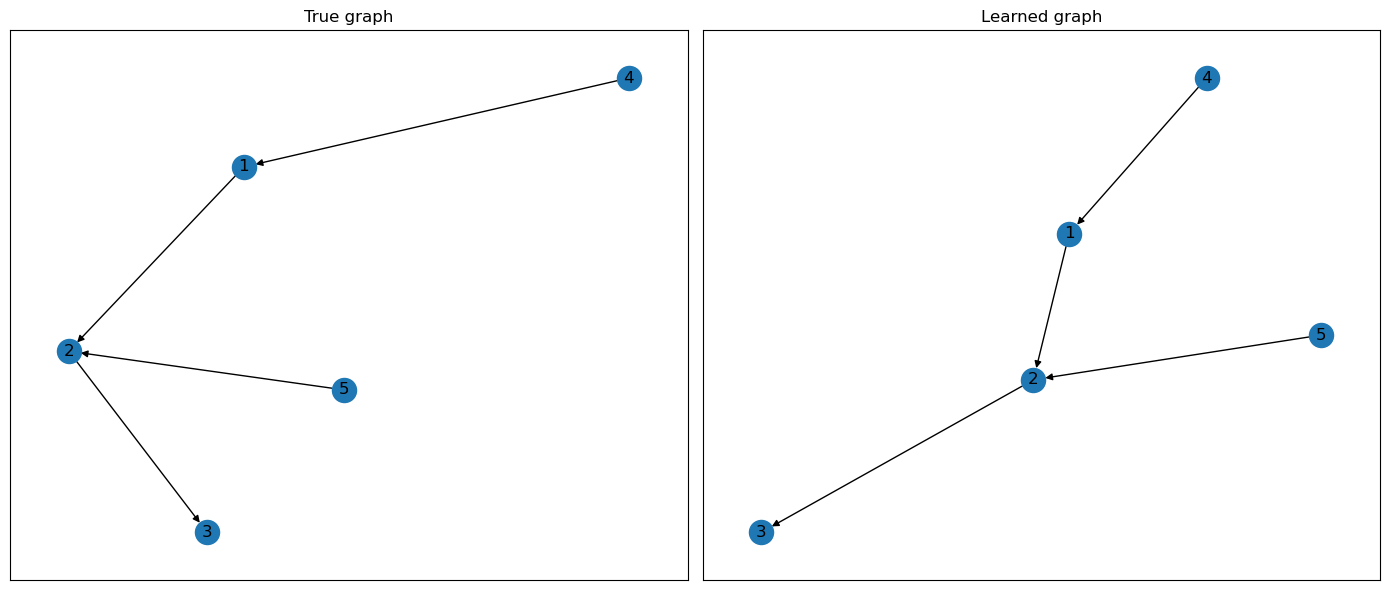

In [62]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

nx.draw_networkx(G_obs, arrows=True, ax=ax[0])
ax[0].set_title("True graph")

nx.draw_networkx(G_learned, arrows=True, ax=ax[1])
ax[1].set_title("Learned graph")

plt.tight_layout()
plt.show()

### Notater
- Metoden ser ut til å virke! Burde sjekke om den skalerer greit med større nettverk.
- Men det er flere svakheter, bl.a. at jeg må være veldig spesifik med hvilken tidsramme jeg skal forvente å se effekt for å lage en modell som kan teste effekt
- I tillegg tror jeg metoden er mindre robust når det er inhibitoriske effekter i nettverket.